In [1]:
import glob
import uproot
import numpy as np
from sbtveto.model.nn_model import NN
import torch

In [2]:
!ls ../NN_data

h5_files  root_files  SBT_new_geo_XYZ.npy  SBT_XYZ.npy	signal


In [3]:
XYZ =np.load("../NN_data/SBT_new_geo_XYZ.npy")

In [4]:
!ls ../NN_data/signal

datafile_EMBG_0_0.h5  datafile_EMBG_0_0.root


In [5]:
neu_files = glob.glob("../NN_data/root_files/*neuDIS*.h5")
#mu_files = glob.glob("../SBT/ml_dataset/*muDIS*.root")
#embg_files = glob.glob("../SBT/ml_dataset/*EMBG*.root")
embg_files = glob.glob("../NN_data/signal/*EMBG*.h5")

In [6]:
embg_files

['../NN_data/signal/datafile_EMBG_0_0.h5']

In [7]:
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import joblib

In [8]:
from torch.utils.data import Dataset, DataLoader
import glob
import torch
import h5py
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import joblib

class AdvancedSBTDataloader(Dataset):
    """SBT data loader"""

    def __init__(self):
        """
        Arguments:
 
        """
        self.files = glob.glob("../NN_data/h5_files/*.h5")[:50] +  glob.glob("../NN_data/signal/*EMBG*.h5")

        self.file_name_mapping = {}
        self.file_number_mapping = {}
        self.scaler = joblib.load('robust_scaler.pkl')

        
        j = 0 
        for f in self.files:
            file = h5py.File(f,'r')
            #print(N)
            for key in file.keys():
                self.file_name_mapping[j] = f
                self.file_number_mapping[j] = key
                j+=1
            file.close()
        self._len = j
                
                            
           

    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        #print(self.file_name_mapping[idx])
        file = h5py.File(self.file_name_mapping[idx], 'r')
        x = np.array(file[self.file_number_mapping[idx]]['data'][:])

        x = np.hstack([x[:854],x[1708:1712]])   
        x = np.expand_dims(x, 0)
        #print(x.shape)
        x = self.scaler.transform(x)
        x = x.flatten()
        y = 0
        if 'neuDIS' in self.file_name_mapping[idx]:
            y = 1
        return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

In [9]:
sbt_data = AdvancedSBTDataloader()
train_loader = DataLoader(sbt_data, batch_size=32,
                        shuffle=True)

In [10]:
#multiple targets 3 targets
#network = NN(2003,3,[32,32,32,16,8], dropout=0)
network = NN(858,1,[32,32,32,16,8], dropout=0)
#network = NN(1712,1,[32,32,32,16,8], dropout=0)

In [11]:
for b in train_loader:
    print(b[0].shape)
    
    network(b[0])
    break

torch.Size([32, 858])


In [12]:
#b[1]

In [13]:
network

NN(
  (_layers): ModuleList(
    (0): Linear(in_features=858, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (_batch_norms): ModuleList(
    (0-1): 2 x BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (_dropout): Dropout(p=0, inplace=False)
  (_output_layer): Linear(in_features=8, out_features=1, bias=True)
)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [15]:
# number of pars in the network
count_parameters(network)

29393

In [16]:
from torch import nn


In [17]:
device='cuda'

model = network
model.cuda()

# Loss and optimizer
BCE_criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

from datetime import datetime

In [18]:
CE_criterion = nn.CrossEntropyLoss()

In [19]:
model = model.cuda()

epoch_log = []
loss_log = []
val_loss_log = []
accuracy_log = []
val_accuracy_log = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
sig = nn.Sigmoid()

In [20]:
epochs = 10
    

for epoch in range(epochs):  
    print(f'Epoch: {epoch+1}')

    running_loss = 0.0
    running_correct = 0.0 
    running_total = 0.0
    actual_loss = 0.0
    # loop over training batches
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # clear gradients
        optimizer.zero_grad()

        # forward propagation
        outputs = model(inputs)

        # compute loss
        labels = labels.unsqueeze(1)
        #print(outputs.shape)
        #print(labels.shape)
        loss =  BCE_criterion(outputs, labels)
        #print(loss)


        # backward propagation
        loss.backward()
        optimizer.step()

        # add batch loss to running loss
        running_loss += loss.item()
        #_, predicted = torch.max(outputs.data, dim = 1)
        predicted = sig(outputs) > 0.5
        running_total += labels.size(0)
        #print(running_total)
        running_correct += (predicted == labels).sum().item()
        del data
        #print(running_total)

        if i % 400 == 399:    
            valcorrect = 0 
            valtotal = 0 
            running_val_loss = 0

            with torch.no_grad():
                # for data in val_loader:

                #     x, labels = data

                #     x = x.to(device)
                #     labels = labels.to(device)

                #     outputs = model(x)
                #     labels = labels.unsqueeze(1)
                #     val_loss =  BCE_criterion(outputs, labels)
                #     # if multiclass
                #     #val_loss =  CE_criterion(outputs, labels)
                #     #_, predicted = torch.max(outputs.data, dim = 1)

                #     predicted = sig(outputs) > 0.5

                #     valtotal += labels.size(0)

                #     valcorrect += (predicted == labels).sum().item()
                    
                #     running_val_loss += val_loss.item() 

                # val_accuracy = 100 * valcorrect / valtotal
                accuracy = 100 * running_correct / running_total
                epoch_num = epoch + 1
                
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)} Train Accuracy = {accuracy:.3f}%')
                # print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)} Val Accuracy = {val_accuracy:.3f}%')
                

    actual_loss = running_loss / running_total
    # actual_val_loss = running_val_loss / valtotal
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    # val_loss_log.append(actual_val_loss)
    accuracy_log.append(accuracy)
    # val_accuracy_log.append(val_accuracy)
    print('\n')
    print(f"Epoch {epoch_num} summary stats:")
    print(f'Train Loss: {actual_loss:.4f}, Train Accuracy = {accuracy:.3f}%')
    # print(f'Val Loss: {actual_val_loss:.4f}, Val Accuracy = {val_accuracy:.3f}%')
    print('\n')
    print('\n')

Epoch: 1
Epoch: 1, Mini-Batches Completed: 400 Train Accuracy = 84.102%
Epoch: 1, Mini-Batches Completed: 800 Train Accuracy = 89.734%
Epoch: 1, Mini-Batches Completed: 1200 Train Accuracy = 91.901%
Epoch: 1, Mini-Batches Completed: 1600 Train Accuracy = 92.984%
Epoch: 1, Mini-Batches Completed: 2000 Train Accuracy = 93.703%


Epoch 1 summary stats:
Train Loss: 0.0061, Train Accuracy = 93.703%




Epoch: 2
Epoch: 2, Mini-Batches Completed: 400 Train Accuracy = 96.766%
Epoch: 2, Mini-Batches Completed: 800 Train Accuracy = 96.867%
Epoch: 2, Mini-Batches Completed: 1200 Train Accuracy = 96.841%
Epoch: 2, Mini-Batches Completed: 1600 Train Accuracy = 96.834%
Epoch: 2, Mini-Batches Completed: 2000 Train Accuracy = 96.806%


Epoch 2 summary stats:
Train Loss: 0.0036, Train Accuracy = 96.806%




Epoch: 3
Epoch: 3, Mini-Batches Completed: 400 Train Accuracy = 96.938%
Epoch: 3, Mini-Batches Completed: 800 Train Accuracy = 96.977%
Epoch: 3, Mini-Batches Completed: 1200 Train Accuracy = 97.096%

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
#torch.save(model.state_dict(), 'SBTveto_vacuum_multiclass_NN_SBT_E_signal_xyz.pth')

In [ ]:
#!ls data

In [60]:
#model.load_state_dict(torch.load("data/SBTveto_vacuum_multiclass_NN_SBT_E_signal_xyz.pth", weights_only=True))
#model.eval()

NN(
  (_layers): ModuleList(
    (0): Linear(in_features=2003, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (_batch_norms): ModuleList(
    (0-1): 2 x BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (_dropout): Dropout(p=0, inplace=False)
  (_output_layer): Linear(in_features=8, out_features=3, bias=True)
)

In [63]:
ypreds=[]
ys =[]


In [65]:
for data in val_loader:

    # apply model to validation batch
    x, labels = data

    x = x.to(device)
    labels = labels.to(device)

    outputs = model(x)
    labels = labels.unsqueeze(1)
    val_loss =  criterion(outputs, labels)

    predicted = sig(outputs.data)
    ys.append(labels.cpu().detach().numpy())
    ypreds.append(predicted.cpu().detach().numpy() > 0.5)

In [66]:
ypred = np.concatenate(ypreds)
true = np.concatenate(ys)

In [67]:
np.sum(ypred==true)/len(ypred)

np.float64(0.9205904810384322)

In [68]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

In [69]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, ypred)

In [70]:
cm

array([[1656,  181],
       [ 131, 1961]])

In [71]:
cm

array([[1656,  181],
       [ 131, 1961]])

In [73]:
preds=ypred

In [74]:
np.sum(preds == true)/true.shape[0]

np.float64(0.9205904810384322)

In [75]:
labels=['signal',r'$\nu$-DIS']#, r'$\mu$-DIS']
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)

In [76]:
cmnew =cm/np.expand_dims(np.sum(cm,1),1)

In [77]:
def plot_errorband(x, y, y_err, label, color):
    plt.plot(x, y, color=color, ls='solid', label=label)
    plt.fill_between(x, y_err[0],y_err[1], color=color, alpha=0.3, lw=0)
   
    
def init_thesis_plot_style():
    my_rc_params = {
        "xtick.direction": "in",
        "xtick.major.size": 8.0,
        "xtick.minor.size": 4.0,
        "xtick.minor.visible": True,
        "xtick.major.width": 1.2,
        "xtick.minor.width": 0.9,
        "ytick.direction": "in",
        "ytick.major.size": 8.0,
        "ytick.minor.size": 4.0,
        "ytick.minor.visible": True,
        "ytick.major.width": 1.2,
        "ytick.minor.width": 0.9,
        "errorbar.capsize": 2,
        "axes.linewidth": 1.2,
        # "font.familiy": "serif",
        "font.size": 14,
        "axes.grid": False,
        "ytick.right": True,
        "xtick.top": True
    }
    return(my_rc_params)
class Tango(object):
    scarlet_red_light = '#ef2929'
    scarlet_red = '#cc0000'
    scarlet_red_dark = '#a40000'

    aluminium_light = '#eeeeec'
    aluminium = '#d3d7cf'
    aluminium_dark = '#babdb6'

    butter_light = '#fce94f'
    butter = '#edd400'
    butter_dark = '#c4a000'

    chameleon_light = '#8ae234'
    chameleon = '#73d216'
    chameleon_dark = '#4e9a06'

    orange_light = '#fcaf3e'
    orange = '#f57900'
    orange_dark = '#ce5c00'

    chocolate_light = '#e9b96e'
    chocolate = '#c17d11'
    chocolate_dark = '#8f5902'

    sky_blue_light = '#729fcf'
    sky_blue = '#3465a4'
    sky_blue_dark = '#204a87'

    plum_light = '#ad7fa8'
    plum = '#75507b'
    plum_dark = '#5c3566'

    slate_light = '#888a85'
    slate = '#555753'
    slate_dark = '#2e3436'

init_thesis_plot_style()
plt.rcParams.update(init_thesis_plot_style())

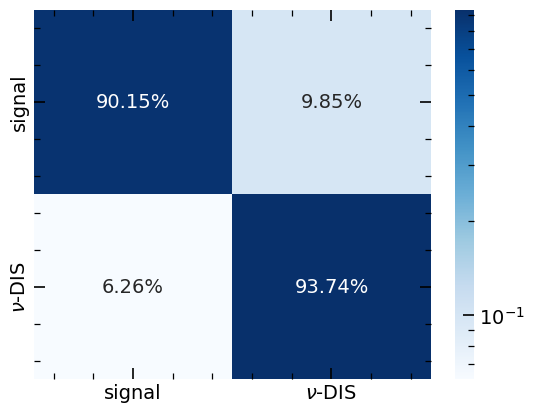

In [78]:
import seaborn as sns
from matplotlib.colors import LogNorm
sns.heatmap(cmnew, 
            fmt='.2%', norm= LogNorm(),
            annot=True,  xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.savefig('NN_SHIP_Dec_Confusion_binary.png')

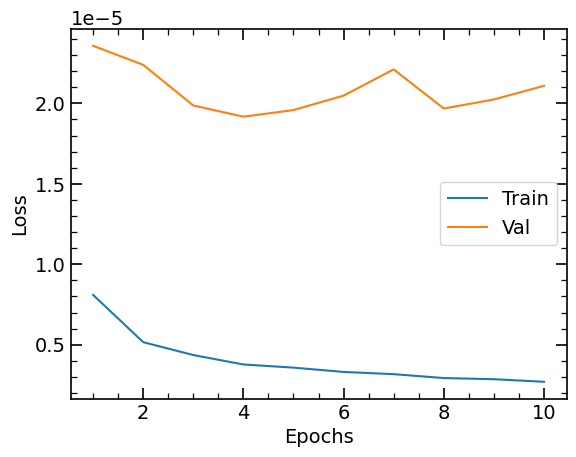

In [130]:
import matplotlib.pyplot as plt
epochs = np.arange(0, len(loss_log)+1)

plt.plot(epochs[1:],np.array(loss_log)*32./len(traindata), label="Train")
plt.plot(epochs[1:],np.array(val_loss_log)*32./len(testdata), label="Val")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

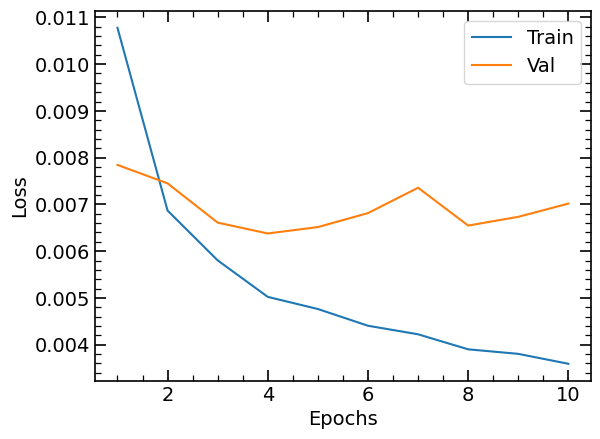

In [127]:
import matplotlib.pyplot as plt
epochs = np.arange(0 ,len(loss_log)+1)

plt.plot(epochs[1:],np.array(loss_log), label="Train")
plt.plot(epochs[1:],np.array(val_loss_log), label="Val")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [131]:
epochs

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])